## Evaluation Of The Impact Geographic Factors On The U.S Real Estate Price.

### Dataset: US Real Esatate

# Project 1


## Introduction

Bayer, P., McMillan, R., & Rueben, K. in their 2002 paper, the causes and consequences of residential segregation, explored the causes and consequences of residential segregation through neighborhood sorting by using Hedonic Prices Method (Rosen,S. 1974). They found that at the zip code level, Black households tend to spend less on housing, leading to a correlation between low-priced communities and higher proportions of Black residents. However, the implications of this phenomenon at the state level and for other racial groups remain  remains unclear. <br><br>

This study aims to investigate the relationship between racial composition at the state level and housing prices. To achieve this, we use data from multiple sources, including US real estate data from Kaggle, economic data (Income& Employment) from the United States Census, and crime rate data from World Population Review.<br><br>

As we apply our filter method, we result in researching on California, Florida, New York, Pennsylvania, Texas, and Washington, each characterized by distinct racial compositions and economic profiles. Our findings suggest that, contrary to expectations, the proportion of Black residents does not show a significant impact on housing prices at the state level. This may be attributed to racial integration or the "averagization" effect. Interestingly, we discover a strong positive correlation between the proportion of Asian and other racial groups with higher housing prices, which implies some hidden mechanisms.

## Variable Explanation

In our study, the dependent variable $Y$ is set as the $price/ft^2$, while the focus is on five independent variables $X$: Land-to-building ratio ($L/B$), crime rate ($CR$), income level ($I$), employment condition ($E$), and racial proportions ($R$). These variables are chosen due to their potential influence on housing prices. <br>
<br>$L/B$ represents how much a structure occupies the total land parcel on which it is located. Different land-to-building ratios influence real estate investment values, with a ratio of 40:60 often considered the "golden ratio." In our study, Land-to-building served as a covariate and is resticted around this optimal proportion.<br>
<br>$CR$ has been verified as an strong influecning factor of housing price in zip code level(Gibbons, S. ,2004). It is necessary to control the variable<br>
<br>$I$ and $E$ are fundamental economic indicators that affect housing demand and affordability. Liu and Serota (2024) showed that these economic factors significantly shape the housing market, and their influence is critical for understanding variations in property prices across different regions.<br>

## Data Cleaning

In [78]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from shapely.geometry import Point


In this section, we will:<br>
1. Modify to the the date format.<br>
2. Remove outliers (IQR)<br>
3. Remove states with small sample size<br>
4. Remove NAN value in dataset
<br><br>
The price indicator in research will be $price/ft^2$.<br>
To avoid difference in how much the structure occupies the land, we will fix the Land-to-building ration around 40:60.

In [79]:
# Load and format the date
df = pd.read_csv(r'C:\Users\BX\github-classroom\ECO225-W2025\eco225-project-code-3039349918\realtor-data.csv')
df.head()
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], format='%Y-%m-%d', errors='coerce')
df = df[(df['prev_sold_date'].isna()) | (df['prev_sold_date'] > '2020-01-01')] #only keep data after 2020
df.dropna(subset=['house_size', 'price', 'acre_lot', 'bath', 'bed'], inplace=True)

Code below verifies that the data is cleaned.

In [80]:
print(df['prev_sold_date'].min())

2020-01-02 00:00:00


In [81]:
# Addding price indicator
df['land_to_building_ratio'] = (df['house_size'] / (df['acre_lot']*43560)).round(2) # land to building ratio
df = df[(df['land_to_building_ratio'] >= 0.55) & (df['land_to_building_ratio'] <= 0.65)] # fixed the ratio
df['price_per_sqft'] = (df['price'] / df['house_size']).round(2) # price per sqft

### Next, we will <br>
1. Group the data by state
2. Removing small size sample and outliers in each state. 
<br>
<br>Specifically:<br>
Remove outliers (IQR)<br>
Remove states with sample size less than 1000.

In [82]:
# calculate the IQR for each state
Q1 = df.groupby('state')['price_per_sqft'].quantile(0.25)
Q3 = df.groupby('state')['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for each state
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# mark the outliers
is_outlier = df.apply(lambda row: row['price_per_sqft'] < lower_bound[row['state']] or row['price_per_sqft'] > upper_bound[row['state']], axis=1)

# drop the outliers
df = df[~is_outlier]

sample_size = 1000
df = df.groupby('state').filter(lambda x: len(x) >= sample_size)

The table below shows the number of houses in each state after removing outliers and filtering out states with fewer than 1,000 houses, which will be researched.

In [83]:
df.groupby('state').size()

state
California      3984
Florida         1620
New York        1001
Pennsylvania    1257
Texas           2132
Washington      1453
dtype: int64

As we have seen in the table, California has the most sample. Therefore, we save Californica Data for further research and merge.

In [84]:

california_data = df[df['state'] == 'California'].copy()
california_data.drop(columns=['acre_lot', 'prev_sold_date','brokered_by', 'status', 'street', 'state', 'city'], inplace=True)


In [85]:
california_data.to_csv(r'C:\Users\BX\github-classroom\ECO225-W2025\eco225-project-code-3039349918\california_data.csv', index=False)

### There will be two main steps in merging data:<br>
1. Import and merging state level data.<br>
2. Import and merging California Zip Code level data.

### State Level

Calculate statistc facts.

In [86]:
state_stats = df.groupby('state')['price_per_sqft'].agg(['mean', 'median','count']).round(2)
state_stats.reset_index(inplace=True)

Now, merging the race in state level

In [87]:
# load the state population data
state_race = pd.read_csv(r"DECENNIALCD1182020.P8-2025-02-05T235235.csv")
# clean the data
state_race.dropna(subset=['Total:'], inplace=True)
state_race.columns = ['state', 'total_population', 'white', 'black', 'native', 'asian', 'pacific', 'other']
columns = ["total_population", 'white', 'black', 'native', 'asian', 'pacific', 'other']
state_race[columns] = state_race[columns].apply(lambda col: col.str.replace(',', ''))
state_race[columns] = state_race[columns].apply(pd.to_numeric, errors='coerce')
# calculate percentage
state_race["white_proportion"] = (state_race["white"] /state_race["total_population"]).round(2)
state_race["black_proportion"] = (state_race["black"] /state_race["total_population"]).round(2)
state_race["asian_proportion"] = (state_race["asian"] /state_race["total_population"]).round(2)
state_race["other_proportion"] = ((state_race['native'] + state_race['pacific'] + state_race['other']) /state_race["total_population"]).round(2)
state_race.drop(columns=['white', 'black', 'native', 'asian', 'pacific', 'other'], inplace=True)
state_race.reset_index(drop=True, inplace=True)
# merge the two dataframes
state_race['state'] = state_race['state'].str.strip()
state_stats['state'] = state_stats['state'].str.strip()
state_stats = state_race.merge(state_stats, on='state')
raceXprice = state_stats.drop(columns=['total_population', 'count'])



Merging employmeny conditions and income.

In [88]:
# Import data, clean data, and formating data
state_income = pd.read_csv(r"ACSDP1Y2023.DP03-2025-02-06T084725.csv")
state_income.drop(columns=['EMPLOYMENT STATUS'])

# Drop rows and columns with all NaN values
state_income = state_income.dropna(how="all", axis=1)

# Extract State names
states = state_income.iloc[::3, 0].values  # Every first row in every 3 rows is a state name

# Extract Estimate and Percent data
df_estimate = state_income.iloc[1::3, 1:].reset_index(drop=True)  # Extract Estimate data to a new dataframe
df_percent = state_income.iloc[2::3, 1:].reset_index(drop=True)  # Extract Percent data to a new dataframe

# Add State column
df_estimate.insert(0, "State", states)
df_percent.insert(0, "State", states)

df_estimate.columns = ["State"] + [col.replace("EMPLOYMENT STATUS!!", "").replace("INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!", "") + " (Estimate)" for col in df_estimate.columns[1:]]
df_percent.columns = ["State"] + [col.replace("EMPLOYMENT STATUS!!", "").replace("INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!", "") + " (Percent)" for col in df_percent.columns[1:]]

# Merge estimate and percent data
df_final = pd.merge(df_estimate, df_percent, on="State")

# Drop columns with all "(X)" values
df_final = df_final.loc[:, ~(df_final.eq("(X)").any())]

# Rename columns
df_final.columns = [
    "state", "Labor Force (Estimate)", "Employed (Estimate)", "Unemployed (Estimate)",
    "Median Household Income (Estimate)", "Mean Household Income (Estimate)", 
    "Per Capita Income (Estimate)", "Median Earnings (Estimate)",
    "Labor Force (Percent)", "Employed (Percent)", "Unemployed (Percent)"
]

# Remove commas and percentage signs and convert to numeric (formatting)
columns = ["Labor Force (Estimate)", "Employed (Estimate)", "Unemployed (Estimate)",
    "Median Household Income (Estimate)", "Mean Household Income (Estimate)", 
    "Per Capita Income (Estimate)", "Median Earnings (Estimate)",
    "Labor Force (Percent)", "Employed (Percent)", "Unemployed (Percent)"]
df_final[columns] = df_final[columns].apply(lambda col: col.str.replace(',', ''))
df_final[columns] = df_final[columns].apply(lambda col: col.str.replace('%', ''))
df_final[columns] = df_final[columns].apply(pd.to_numeric, errors='coerce')

In [89]:
# Merge the two dataframes
state_stats = state_stats.merge(df_final, on='state')

In [90]:
raceXpriceXincome = state_stats.drop(columns=['total_population', 'count', 'Labor Force (Estimate)', 'Unemployed (Estimate)', 'Median Earnings (Estimate)', 'Labor Force (Percent)', 'Unemployed (Percent)', 'Median Household Income (Estimate)', 'Employed (Percent)', 'median', 'mean'])

Import U.S Violent Crime Rate. Merge by State.

In [91]:
crime = pd.read_csv(r"crime-rate-by-state-2024.csv")
crime.drop(columns=['Population2020', 'CrimeReported', 'CrimeViolent', 'CrimeViolentRate', 'CrimeNonViolent', 'CrimeNonViolentRate'], inplace=True)
state_stats = state_stats.merge(crime, on='state')
raceXprice = raceXprice.merge(crime, on='state')

### California Zip Code Level

Group by Zip Code, calculating the average of price indicator, $price/ft^2$, in each Zip Code.

In [92]:
california_data = california_data.groupby('zip_code').agg({'price_per_sqft': 'mean', 'bed': 'mean', 'land_to_building_ratio': 'mean'}).reset_index()


In [93]:
state_df = gpd.read_file("cb_2016_us_state_5m.zip")

Merging price indicator.

In [94]:
zip_code_df = gpd.read_file("ZipCodes_3170383398510875265.zip")
zip_code_df = zip_code_df.to_crs(state_df.crs)
zip_code_df.drop(columns=["POPULATION", "POP_SQMI", "STATE"], inplace=True)

california_data.rename(columns={"zip_code": "ZIP_CODE"}, inplace=True)
california_data["ZIP_CODE"] = california_data["ZIP_CODE"].astype(str).str.split(".").str[0]
zip_code_df["ZIP_CODE"] = zip_code_df["ZIP_CODE"].astype(str)
merged_df = california_data.merge(zip_code_df, on="ZIP_CODE", how="inner")

In [95]:
county_df = gpd.read_file("ca_counties.zip")

In [96]:
county_df.size

1160

In [97]:
county_df.head(10)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-13440081.316 4150394.004, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-13428575.483 4627725.227, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-13283668.940 4059436.934, -13..."
5,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,"MULTIPOLYGON (((-13214002.519 4051462.857, -13..."
6,06,097,01657246,06097,Sonoma,Sonoma County,06,H1,G4020,488,42220,None,A,4.080764e+09,4.981823e+08,+38.5251824,-122.9261095,486513.254292,7.492856e+09,"POLYGON ((-13685069.766 4623872.832, -13685073..."
7,06,031,00277280,06031,Kings,Kings County,06,H1,G4020,260,25260,None,A,3.600884e+09,3.162664e+06,+36.0724780,-119.8155301,354668.809276,5.528560e+09,"POLYGON ((-13353767.857 4335831.240, -13353767..."
8,06,073,00277301,06073,San Diego,San Diego County,06,H1,G4020,None,41740,None,A,1.090437e+10,8.174046e+08,+33.0236041,-116.7761174,553042.602989,1.672201e+10,"POLYGON ((-13073075.796 3919158.524, -13074423..."
9,06,061,00277295,06061,Placer,Placer County,06,H1,G4020,472,40900,None,A,3.644306e+09,2.464666e+08,+39.0620323,-120.7227181,533218.198323,6.462795e+09,"POLYGON ((-13476944.153 4722608.150, -13476936..."


In [98]:

county_geo = county_df[['geometry', 'NAME']].copy()
county_geo.set_crs(epsg=3857, inplace=True)
county_geo = county_geo.to_crs(epsg=4326)
county_geo.rename(columns={'NAME': 'County'}, inplace=True)
county_geo['County'] = county_geo['County'].str.strip()

In [99]:
county_geo.size

116

In [100]:
county_geo.head(10)

,geometry,County
0,"POLYGON ((-120.65560 39.69357, -120.65554 39.6...",Sierra
1,"POLYGON ((-121.18858 38.71431, -121.18732 38.7...",Sacramento
2,"MULTIPOLYGON (((-120.73430 34.90069, -120.7343...",Santa Barbara
3,"POLYGON ((-120.63095 38.34111, -120.63058 38.3...",Calaveras
4,"MULTIPOLYGON (((-119.32923 34.22784, -119.3292...",Ventura
5,"MULTIPOLYGON (((-118.70340 34.16860, -118.7033...",Los Angeles
6,"POLYGON ((-122.93507 38.31396, -122.93511 38.3...",Sonoma
7,"POLYGON ((-119.95894 36.25547, -119.95894 36.2...",Kings
8,"POLYGON ((-117.43744 33.17953, -117.44955 33.1...",San Diego
9,"POLYGON ((-121.06545 39.00654, -121.06538 39.0...",Placer


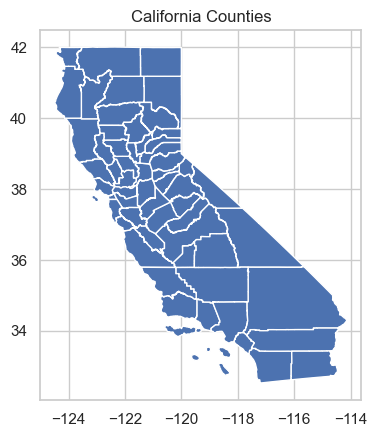

In [101]:
county_geo.plot()
plt.title("California Counties")
plt.show()

Import California Race Data and merge.

In [102]:
ca_race = pd.read_csv("CA race data.csv")

# Drop rows with "Margin of Error" in "Label (Grouping)"
ca_race_cleaned = ca_race[ca_race['Label (Grouping)'] != '    Margin of Error'].reset_index(drop=True)\

# Rename "Label (Grouping)" to "ZIP_CODE"
ca_race_cleaned.rename(columns={'Label (Grouping)': 'ZIP_CODE'}, inplace=True)

# Select rows with "Estimate" in "ZIP_CODE"
estimate_rows = ca_race_cleaned[ca_race_cleaned['ZIP_CODE'] == '    Estimate']

# Index of "Estimate" rows
zip_codes = ca_race_cleaned[ca_race_cleaned['ZIP_CODE'].str.startswith(' ->')].reset_index(drop=True)

# Extract ZIP_CODE
zip_codes['ZIP_CODE'] = zip_codes['ZIP_CODE'].str.split().str[-1]

zip_codes.dropna(how='all', axis=1, inplace=True)

# Extract Estimate data and Concatenate ZIP_CODE
estimate_rows = estimate_rows.drop(columns=['ZIP_CODE']).reset_index(drop=True)

# Repeat ZIP_CODE rows to match the length of Estimate rows
zip_codes = pd.concat([zip_codes] * (len(estimate_rows) // len(zip_codes)), ignore_index=True)

# Concatenate ZIP_CODE and Estimate data
final_data = pd.concat([zip_codes, estimate_rows], axis=1)

ca_cleaned = final_data.rename(columns={
    'Total:!!White alone': 'Estimate White alone',
    'Total:!!Black or African American alone': 'Estimate Black alone',
    'Total:!!Asian alone': 'Estimate Asian alone'
})

# Remove commas and convert to numeric
for col in ['Total:', 'Estimate White alone', 'Estimate Black alone', 'Estimate Asian alone']:
    ca_cleaned[col] = pd.to_numeric(ca_cleaned[col].str.replace(',', ''), errors='coerce')

# Calculate Other Race
ca_cleaned['Estimate Other Race'] = ca_cleaned['Total:'] - (
    ca_cleaned['Estimate White alone'] + ca_cleaned['Estimate Black alone'] + ca_cleaned['Estimate Asian alone']
)

# Calculate Percentage
ca_cleaned['Percent White alone'] = (ca_cleaned['Estimate White alone'] / ca_cleaned['Total:']) * 100
ca_cleaned['Percent Black alone'] = (ca_cleaned['Estimate Black alone'] / ca_cleaned['Total:']) * 100
ca_cleaned['Percent Asian alone'] = (ca_cleaned['Estimate Asian alone'] / ca_cleaned['Total:']) * 100
ca_cleaned['Percent Other Race'] = (ca_cleaned['Estimate Other Race'] / ca_cleaned['Total:']) * 100

# Keep relevant columns
ca_cleaned = ca_cleaned[['ZIP_CODE', 'Percent White alone', 'Percent Black alone', 'Percent Asian alone', 'Percent Other Race']]

merged_df = ca_cleaned.merge(merged_df, on="ZIP_CODE", how="inner")

Import Califonia Income Data and merge.

In [103]:
ca_income = pd.read_csv("CA Income.csv")
# Calculate relative position   
ca_income['row_position'] = ca_income.index % 19  # Calculate row position

# Keep rows with row_position less than 3
ca_income_filtered = ca_income[ca_income['row_position'] < 3].drop(columns=['row_position']).reset_index(drop=True)

# Drop rows with "Margin of Error" in "Label (Grouping)"
ca_income_filtered

ca_income_filtered_estimates = ca_income_filtered[ca_income_filtered['Label (Grouping)'] == '        Estimate'].reset_index(drop=True)
ca_income_filtered = ca_income_filtered[ca_income_filtered['Label (Grouping)'] != '    Total'].reset_index(drop=True)
ca_income_filtered = ca_income_filtered[ca_income_filtered['Label (Grouping)'] != '        Estimate'].reset_index(drop=True)
ca_income_filtered.drop(columns=['Population 16 years and over with earnings!!FULL-TIME, YEAR-ROUND WORKERS WITH EARNINGS!!Mean earnings (dollars) for full-time, year-round workers with earnings'], inplace=True)
ca_income_filtered_estimates.drop(columns=['Label (Grouping)'], inplace=True)
ca_income_filtered = ca_income_filtered.merge(ca_income_filtered_estimates, left_index=True, right_index=True, how="inner")
ca_income_filtered.rename(columns={'Label (Grouping)': 'ZIP_CODE',
                   'Population 16 years and over with earnings!!FULL-TIME, YEAR-ROUND WORKERS WITH EARNINGS!!Mean earnings (dollars) for full-time, year-round workers with earnings': 'Mean Income'},
          inplace=True)

# Extract ZIP_CODE
ca_income_filtered['ZIP_CODE'] = ca_income_filtered['ZIP_CODE'].str.extract(r'(\d{5})')

# Replace 'N' and '-' with None 
ca_income_filtered['Mean Income'] = ca_income_filtered['Mean Income'].replace({'N': None, '-': None})

ca_income_filtered['Mean Income'] = ca_income_filtered['Mean Income'].str.replace(',', '')
ca_income_filtered['Mean Income'] = pd.to_numeric(ca_income_filtered['Mean Income'], errors='coerce')
ca_income_filtered.dropna(subset=['Mean Income'], inplace=True)

# Merge the two dataframes
merged_df = merged_df.merge(ca_income_filtered, on="ZIP_CODE", how="inner")

Improt California Zip Code level Unemployment rate.

In [104]:
ca_unemp = pd.read_csv('CA EMP.csv')
keep_indices = [i for i in range(len(ca_unemp)) if i % 13 == 0 or i % 13 > 10]

# Filter the data
ca_unemp_filtered = ca_unemp.iloc[keep_indices].reset_index(drop=True)
ca_unemp_filtered_estimates = ca_unemp_filtered[ca_unemp_filtered['Label (Grouping)'] == '        Estimate'].reset_index(drop=True)
ca_unemp_filtered_estimates.drop(columns=['Label (Grouping)'], inplace=True)
ca_unemp_filtered = ca_unemp_filtered[ca_unemp_filtered['Label (Grouping)'] != '        Margin of Error'].reset_index(drop=True)
ca_unemp_filtered = ca_unemp_filtered[ca_unemp_filtered['Label (Grouping)'] != '        Estimate'].reset_index(drop=True)
ca_unemp_filtered.drop(columns=['Population 20 to 64 years'], inplace=True)
ca_unemp_filtered.rename(columns={'Label (Grouping)': 'ZIP_CODE'}, inplace=True)
ca_unemp_filtered["ZIP_CODE"] = ca_unemp_filtered["ZIP_CODE"].str.extract(r'(\d{5})')
ca_unemp_filtered_estimates.rename(columns={'Population 20 to 64 years': 'Unemployment Rate'}, inplace=True)
ca_unemp_filtered = pd.concat([ca_unemp_filtered, ca_unemp_filtered_estimates], axis=1)
ca_unemp_filtered['Unemployment Rate'] = ca_unemp_filtered['Unemployment Rate'].str.replace('%', '')
ca_unemp_filtered['Unemployment Rate'] = pd.to_numeric(ca_unemp_filtered['Unemployment Rate'], errors='coerce')
merged_df = merged_df.merge(ca_unemp_filtered, on="ZIP_CODE", how="inner")
merged_df.head()

,ZIP_CODE,Percent White alone,Percent Black alone,Percent Asian alone,Percent Other Race,price_per_sqft,bed,land_to_building_ratio,PO_NAME,SQMI,geometry,Mean Income,Unemployment Rate
0,90002,15.486868,15.462217,1.695269,67.355646,319.1500,4.000,0.55000,Los Angeles,3.10,"POLYGON ((-118.23091 33.95789, -118.23111 33.9...",48213.0,9.4
1,90003,12.888381,16.747085,0.369554,69.994980,288.9860,3.800,0.58000,Los Angeles,3.51,"POLYGON ((-118.26518 33.98924, -118.26956 33.9...",44361.0,8.5
2,90004,27.576303,4.534022,25.212426,42.677248,508.9975,10.625,0.58375,Los Angeles,3.12,"POLYGON ((-118.28446 34.08358, -118.30913 34.0...",85587.0,7.4
3,90005,18.533048,5.548817,32.580587,43.337549,460.3000,6.000,0.59500,Los Angeles,1.56,"POLYGON ((-118.28431 34.06370, -118.31035 34.0...",69143.0,6.3
4,90006,16.286781,3.422597,19.019061,61.271561,410.9140,7.800,0.59800,Los Angeles,1.87,"POLYGON ((-118.28425 34.05587, -118.29219 34.0...",49802.0,6.0


In [105]:
regression_data = merged_df.drop(columns=['geometry', 'ZIP_CODE', 'PO_NAME', 'SQMI'])
regression_data.head()

,Percent White alone,Percent Black alone,Percent Asian alone,Percent Other Race,price_per_sqft,bed,land_to_building_ratio,Mean Income,Unemployment Rate
0,15.486868,15.462217,1.695269,67.355646,319.1500,4.000,0.55000,48213.0,9.4
1,12.888381,16.747085,0.369554,69.994980,288.9860,3.800,0.58000,44361.0,8.5
2,27.576303,4.534022,25.212426,42.677248,508.9975,10.625,0.58375,85587.0,7.4
3,18.533048,5.548817,32.580587,43.337549,460.3000,6.000,0.59500,69143.0,6.3
4,16.286781,3.422597,19.019061,61.271561,410.9140,7.800,0.59800,49802.0,6.0


## Summary Statistics Table

In state level, California and New York have high housing prices, with lower white population proportions (41% and 55%). In contrast, Pennsylvania has lower housing prices and a higher white population proportion (75%).  <br>
<br>In state level $CR$ seems doesn't significantly relate to housing price. This might becasue different cities within a state may have vastly different $CR$. Therefore, the impact is "averaged" out. Large-scale data may not accurately reflect the direct impact of $CR$ variations in individual regions on housing prices.<br>
<br>Housing prices correlate positively with Asian(0.96/0.95) and other minority proportions(0.79/0.77), but show little correlation with Black population proportions(-0.53/-0.43). This impies the relation between housing price and Black population proportions are weak. However, there might be some mechanisms behind Asian and other races and the housing price.<br><br>
We suggest economic factors and urbanization factors play a key role.

In [106]:
raceXpriceXincome.to_csv(r'E:\Desktop\ECO225\W5\raceXpriceXincome.csv', index=False)
raceXpriceXincome.set_index('state', inplace=True)

# set the style of the table
styled_raceXpriceXincome = raceXpriceXincome.sort_values(['white_proportion']).style\
    .set_caption("Table 1: States vs. Income Housing Price").set_table_styles(common_styles)\
    .format("{:.2f}")  # keep two decimal places

# Display formatting DataFrame
display(styled_raceXpriceXincome)

# Display the correlation matrix
styled_corr = raceXpriceXincome.corr().style\
    .set_caption("Table 2: Correlation Matrix: Race Proportion & Econmic Factors").set_table_styles(common_styles)\
    .format("{:.2f}")  # keep two decimal places

display(styled_corr)


,white_proportion,black_proportion,asian_proportion,other_proportion,Employed (Estimate),Mean Household Income (Estimate),Per Capita Income (Estimate)
state,,,,,,,
California,0.41,0.06,0.15,0.23,19026566.00,134491.00,48013.00
Texas,0.50,0.12,0.05,0.15,14926761.00,106549.00,39775.00
New York,0.55,0.15,0.10,0.12,9600693.00,122227.00,48847.00
Florida,0.58,0.15,0.03,0.08,10731195.00,103634.00,41902.00
Washington,0.67,0.04,0.09,0.09,3887150.00,129161.00,52011.00
Pennsylvania,0.75,0.11,0.04,0.04,6400011.00,102578.00,42605.00


,white_proportion,black_proportion,asian_proportion,other_proportion,Employed (Estimate),Mean Household Income (Estimate),Per Capita Income (Estimate)
white_proportion,1.00,0.00,-0.58,-0.94,-0.91,-0.43,0.01
black_proportion,0.00,1.00,-0.56,-0.31,0.05,-0.68,-0.59
asian_proportion,-0.58,-0.56,1.00,0.78,0.43,0.94,0.71
other_proportion,-0.94,-0.31,0.78,1.00,0.87,0.63,0.18
Employed (Estimate),-0.91,0.05,0.43,0.87,1.00,0.19,-0.29
Mean Household Income (Estimate),-0.43,-0.68,0.94,0.63,0.19,1.00,0.87
Per Capita Income (Estimate),0.01,-0.59,0.71,0.18,-0.29,0.87,1.00


In [108]:
# 保存 raceXprice 的 styled 表格为 HTML
styled_raceXpriceXincome.to_html("raceXprice_table.html")

# 保存 correlation matrix 的 styled 表格为 HTML
styled_corr.to_html("correlation_matrix_table.html")

States vs. Income Housing Price table shows that states like California and New York offer higher income($48013 per capita, $48847 per capita respectively) and more job opportunities, attracting minorities and immgrants.

Closer look on correrlation between states level economic factors(Employed, Househould Income, and Per Caplita Income) and Asian with other race groups shows that there is a strong positive relation. A resonable explanation could be better career prospects and access to wealth drives migration to these states.

## Plots

#### Bubble Plot (Relation among $CR$, housing price and racial proportion)

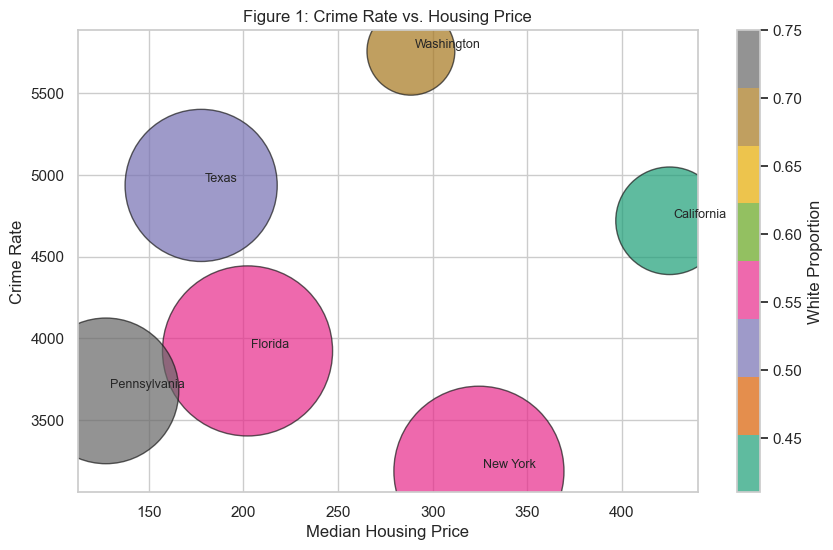

In [109]:
raceXpricecopy = raceXprice.copy().reset_index()
# Create bubble plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=raceXpricecopy['median'], 
    y=raceXpricecopy['CrimeRate'], 
    s=raceXpricecopy['black_proportion'] * 100000, 
    c=raceXpricecopy['white_proportion'],         # Use white proportion to represent color
    cmap='Dark2',
    alpha=0.7,
    edgecolors='k'
)

plt.xlabel('Median Housing Price')
plt.ylabel('Crime Rate')
plt.title('Figure 1: Crime Rate vs. Housing Price')

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('White Proportion')

# Display state abbreviation
for idx, row in raceXpricecopy.iterrows():
    plt.text(row['median']+2, row['CrimeRate']+20, row['state'], fontsize=9)

plt.show()

The bubble plot shows that states with different White population proportions are nearly randomly distributed in the crime rate and price space. This indicates that, at the state level, racial proportions do not have a significant impact on crime rates and housing prices.

#### Reg plots that shows the relation between racial proportions and median house price

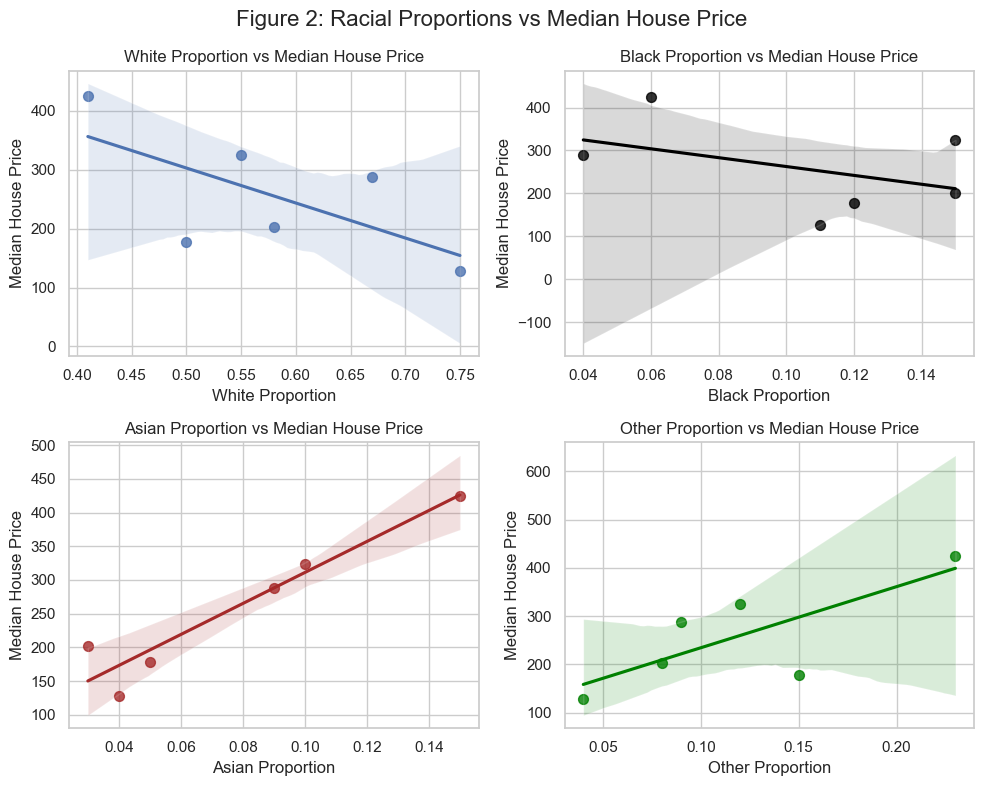

In [114]:
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. white race percentage vs median house price
sns.regplot(ax=axes[0, 0], x='white_proportion', y='median', data=state_stats, scatter_kws={'s':50})
axes[0, 0].set_title('White Proportion vs Median House Price')
axes[0, 0].set_xlabel('White Proportion')
axes[0, 0].set_ylabel('Median House Price')

# 2. black race percentage vs median house price
sns.regplot(ax=axes[0, 1], x='black_proportion', y='median', data=state_stats, scatter_kws={'s':50}, color='black')
axes[0, 1].set_title('Black Proportion vs Median House Price')
axes[0, 1].set_xlabel('Black Proportion')
axes[0, 1].set_ylabel('Median House Price')

# 3. asian percentage vs median house price
sns.regplot(ax=axes[1, 0], x='asian_proportion', y='median', data=state_stats, scatter_kws={'s':50}, color='brown')
axes[1, 0].set_title('Asian Proportion vs Median House Price')
axes[1, 0].set_xlabel('Asian Proportion')
axes[1, 0].set_ylabel('Median House Price')

# 4. other percentage vs median house price
sns.regplot(ax=axes[1, 1], x='other_proportion', y='median', data=state_stats, scatter_kws={'s':50}, color='green')
axes[1, 1].set_title('Other Proportion vs Median House Price')
axes[1, 1].set_xlabel('Other Proportion')
axes[1, 1].set_ylabel('Median House Price')

fig.suptitle('Figure 2: Racial Proportions vs Median House Price', fontsize=16)


plt.tight_layout()
plt.show()

From the plots, we can see that there is a strong positive relationship between the percentage of Asians and housing prices. This might be due to economic factors. California and New York are highly developed, resulting in more job opportunities. Therefore, they attract more immigrants from different races, including Asians.

The relationship between the proportions of White and Black populations and housing prices is similar and weak. This suggests racial integration.

#### Heat map shows correlation between varaibles

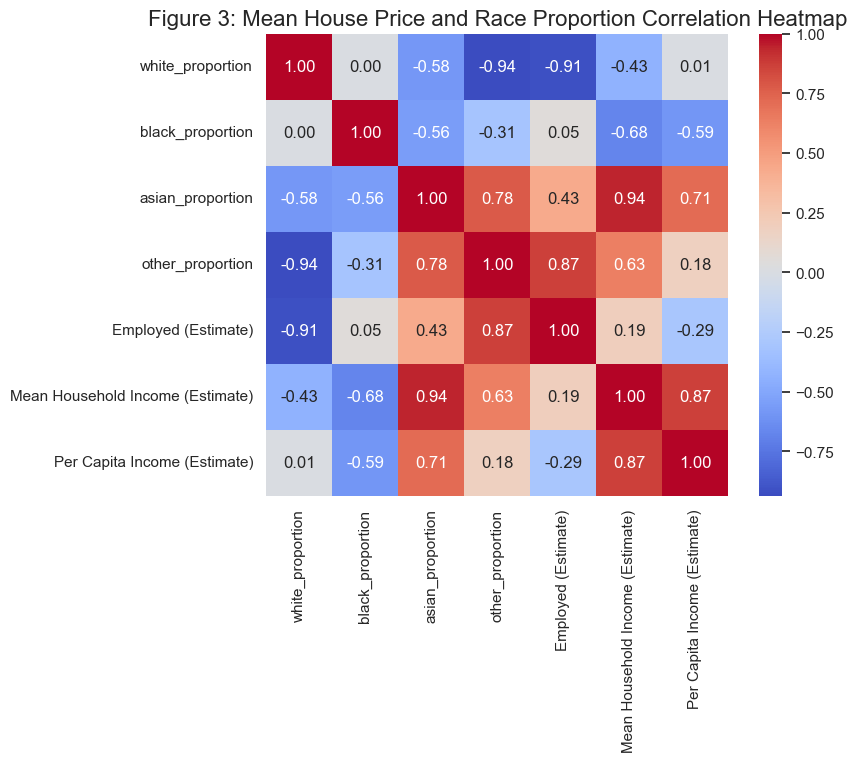

In [115]:
meandata = raceXprice[["mean"]]
plt.figure(figsize=(8, 6))
sns.heatmap(raceXpriceXincome.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Figure 3: Mean House Price and Race Proportion Correlation Heatmap", fontsize=16)

plt.show()

The heat map shows a strong correlation between the Asian population and other races in states with high income and more employment opportunities. This verifies the hypothesis that job opportunities and income attract immigrants. Therefore, states with better economic conditions have a more diversified racial distribution

#### Bar Chart Explored Black and White Population Distribution

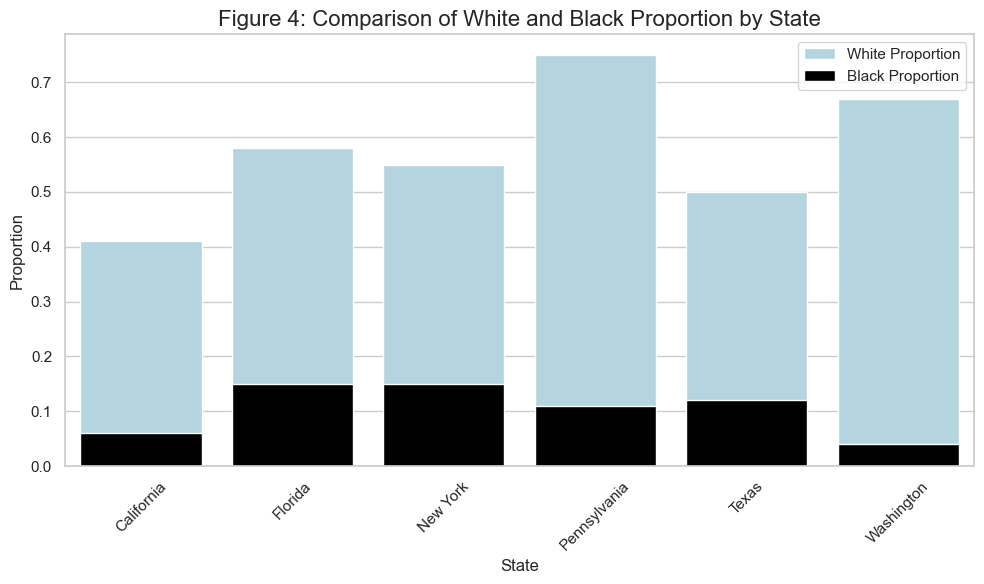

In [116]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='white_proportion', data=raceXprice, color='lightblue', label='White Proportion')
sns.barplot(x='state', y='black_proportion', data=raceXprice, color='black', label='Black Proportion')

# set the title and labels
plt.title('Figure 4: Comparison of White and Black Proportion by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# set the x-axis labels
plt.xticks(rotation=45)

# add the legend
plt.legend()

# display the plot
plt.tight_layout()
plt.show()

The Black population seems evenly distributed at the state level, which suggests that racial segregation is not significant at the state level. Therefore, under the 'averaging' effect, the proportion of the Black population has a weak or no relationship with housing prices.

## Connection

So far, our analysis at the state level suggests that the black population does not appear to have a significant impact on housing prices, while the Asian and other minority populations show a strong correlation with housing prices. Based on this observation, we have developed two hypotheses:<br>
1. Racial integration has led to a more even distribution of the black population, thereby reducing its correlation with housing prices.
2. Economic factors, such as employment and income, have driven minority groups to reside in higher-priced housing areas.<br>
<br>
<br>
However, both hypotheses still require further verification. In the next phase, we will conduct a more in-depth analysis of a selected state, California, to seek supporting evidence for these assumptions.

# Project Two

## The message

We found that:<br>
1. Due to racial integration, the correlation of Housing price and the Black population proportion is weak.
2. Regions with high housing prices tend to have strong economic conditions, attracting new immigrants and increasing racial diversity.

## visualization

The scatter plot displays the population percentage on the X-axis, with the Black and Asian populations represented by blue and red points, respectively. The left Y-axis corresponds to our price indicator, while the right Y-axis represents the mean income.

Notably, the blue points form a cluster on the left side of the graph, suggesting that the Black population is relatively evenly distributed across different ZIP code areas. In contrast, the Asian population, consisting largely of new immigrants, appears to be distributed unevenly.

A close look on the regression line reveals that the correlation between housing prices and income for the Black population is weak. However, there is a strong positive correlation between the Asian population and both housing prices and income. This pattern suggests that new immigrants, including Asians, are primarily driven by better employment opportunities.

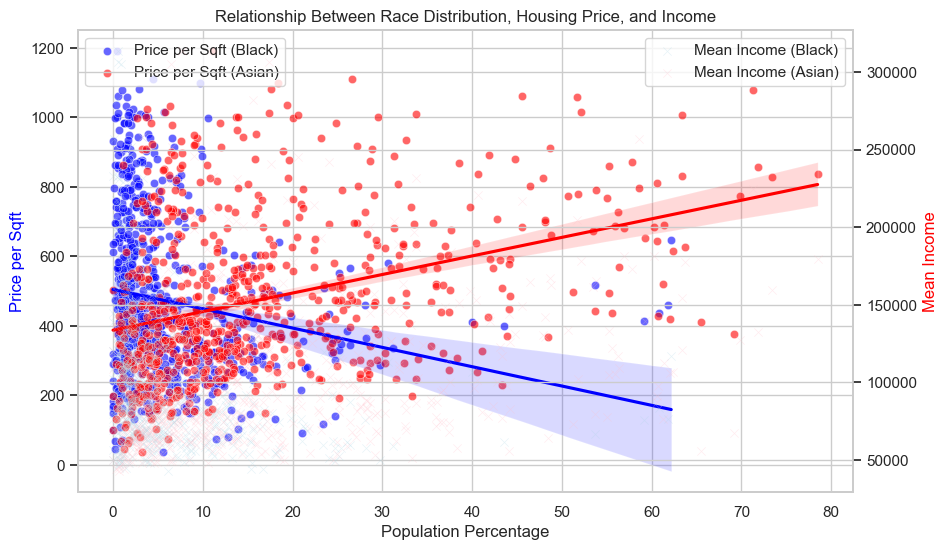

In [37]:
# set the style of the table
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Set the transparency
alpha_value = 0.6

# price per sqft
sns.scatterplot(data=merged_df, x="Percent Black alone", y="price_per_sqft", 
                color="blue", alpha=alpha_value, label="Price per Sqft (Black)", marker="o", ax=ax1)
sns.scatterplot(data=merged_df, x="Percent Asian alone", y="price_per_sqft", 
                color="red", alpha=alpha_value, label="Price per Sqft (Asian)", marker="o", ax=ax1)

# Mean Income
sns.scatterplot(data=merged_df, x="Percent Black alone", y="Mean Income", 
                color="lightblue", alpha=0.3, label="Mean Income (Black)", marker="x", ax=ax2)
sns.scatterplot(data=merged_df, x="Percent Asian alone", y="Mean Income", 
                color="pink", alpha=0.3, label="Mean Income (Asian)", marker="x", ax=ax2)

# Regression line
sns.regplot(data=merged_df, x="Percent Black alone", y="price_per_sqft", 
            scatter=False, color="blue", ax=ax1)
sns.regplot(data=merged_df, x="Percent Asian alone", y="price_per_sqft", 
            scatter=False, color="red", ax=ax1)

# Axis labels
ax1.set_xlabel("Population Percentage")
ax1.set_ylabel("Price per Sqft", color="blue")
ax2.set_ylabel("Mean Income", color="red")

# Graph legend
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Title
plt.title("Relationship Between Race Distribution, Housing Price, and Income")

# Show the plot
plt.show()



## Maps and Interpretations

Import State Shape.

In [38]:
state_df = gpd.read_file("cb_2016_us_state_5m.zip")

### Map: Housing Price

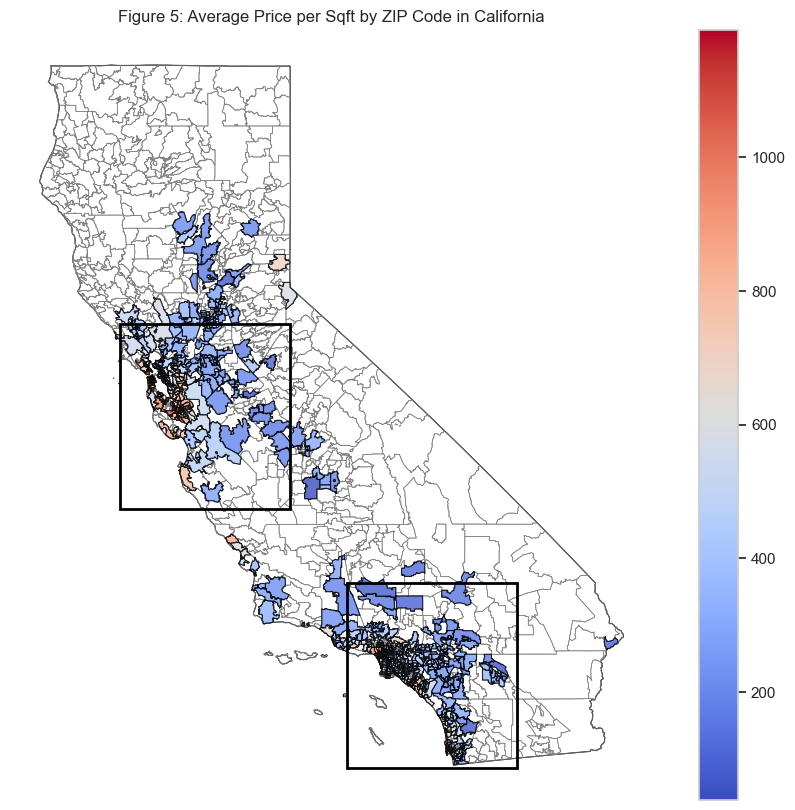

In [117]:
from matplotlib.patches import Rectangle

gdf = gpd.GeoDataFrame(merged_df, geometry="geometry")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Draw the map
state_df.query("NAME == 'California'").plot(ax=ax, edgecolor="black", color="white", linewidth=0.8)

# Overlay ZIP Code boundaries
zip_code_df.plot(ax=ax, edgecolor="gray", linewidth=0.5, facecolor="none")

# Adding data
gdf.plot(column="price_per_sqft", 
         cmap="coolwarm",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax)

# Draw the first target area's rectangle
rect1 = Rectangle((-123, 36), 3, 2.5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect1)

# Draw the second target area's rectangle
rect2 = Rectangle((-119, 32.5), 3, 2.5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect2)

# ratio of the y-axis to the x-axis
ax.set_aspect(1.3)
ax.axis("off")

# Title
plt.title("Figure 5: Average Price per Sqft by ZIP Code in California")

# Show the plot
plt.show()

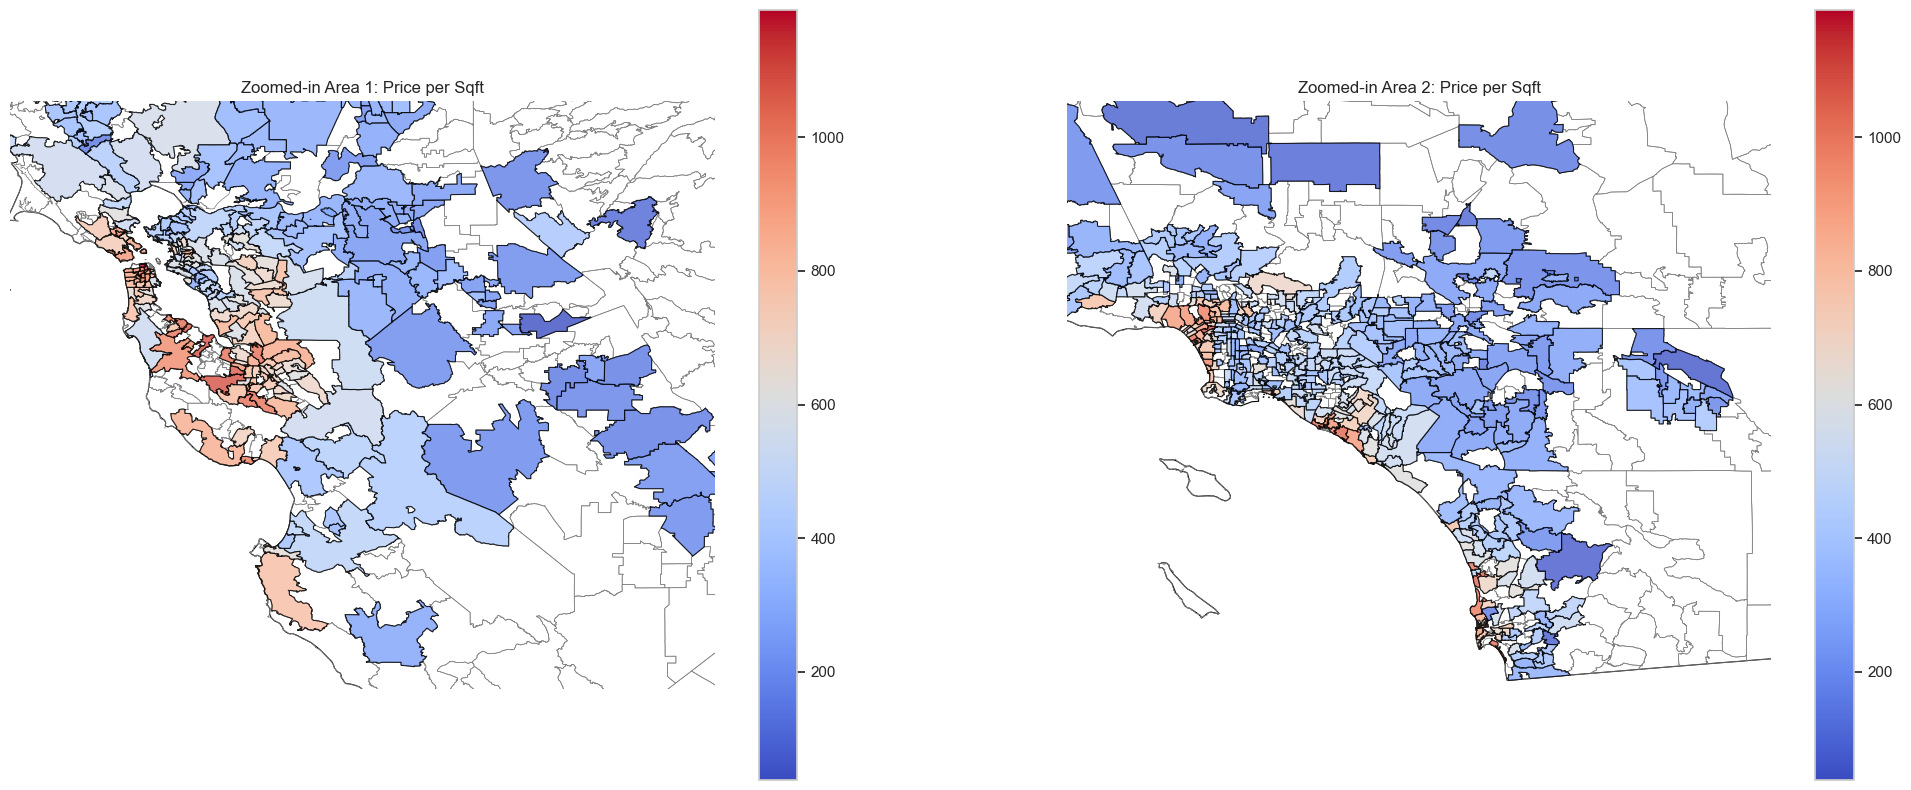

In [40]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# First subplot
xmin1, ymin1, xmax1, ymax1 = -123, 36, -120, 38.5

# Draw the first target area
state_df.query("NAME == 'California'").plot(ax=ax1, edgecolor="black", color="white", linewidth=0.8)
zip_code_df.plot(ax=ax1, edgecolor="gray", linewidth=0.5, facecolor="none")
gdf.plot(column="price_per_sqft", 
         cmap="coolwarm",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax1)

# Set the x and y limits for the first subplot
ax1.set_xlim(xmin1, xmax1)
ax1.set_ylim(ymin1, ymax1)

# Set the aspect ratio and turn off the axis
ax1.set_aspect(1)
ax1.axis("off")
ax1.set_title("Zoomed-in Area 1: Price per Sqft")


# Define the second target area's boundaries
xmin2, ymin2, xmax2, ymax2 = -119, 32.5, -116, 35

# Draw the second target area
state_df.query("NAME == 'California'").plot(ax=ax2, edgecolor="black", color="white", linewidth=0.8)
zip_code_df.plot(ax=ax2, edgecolor="gray", linewidth=0.5, facecolor="none")
gdf.plot(column="price_per_sqft", 
         cmap="coolwarm",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax2)

# Set the x and y limits for the second subplot
ax2.set_xlim(xmin2, xmax2)
ax2.set_ylim(ymin2, ymax2)

# Set the aspect ratio and turn off the axis
ax2.set_aspect(1)
ax2.axis("off")
ax2.set_title("Zoomed-in Area 2: Price per Sqft")

# Show the plot
plt.show()

At the ZIP code level, we map housing prices using our $Y$ variable, the price indicator $price/ft^2$. The map highlights high-price regions in red and low-price regions in blue. <br>
Based on existing data, we observe that zip code areas with an active housing market and higher prices are concentrated along the coastline. Further insights will be identified after mapping other $X$ variables.

### Map: Black Distribution

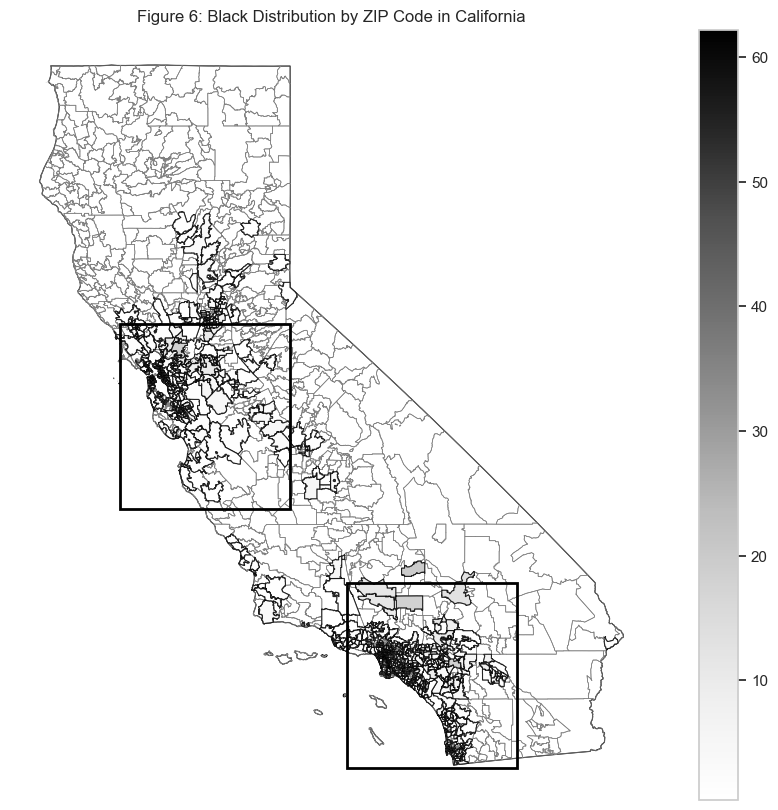

In [118]:
from matplotlib.patches import Rectangle

gdf = gpd.GeoDataFrame(merged_df, geometry="geometry")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Draw the map
state_df.query("NAME == 'California'").plot(ax=ax, edgecolor="black", color="white", linewidth=0.8)

# Overlay ZIP Code boundaries
zip_code_df.plot(ax=ax, edgecolor="gray", linewidth=0.5, facecolor="none")

# Adding data
gdf.plot(column="Percent Black alone", 
         cmap="Greys",
         vmin= 0.4,
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax)

# Draw the first target area's rectangle
rect1 = Rectangle((-123, 36), 3, 2.5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect1)

# Draw the second target area's rectangle
rect2 = Rectangle((-119, 32.5), 3, 2.5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect2)

# Aspect ratio of the y-axis to the x-axis
ax.set_aspect(1.3)
ax.axis("off")

# Title
plt.title("Figure 6: Black Distribution by ZIP Code in California")

# Show the plot
plt.show()

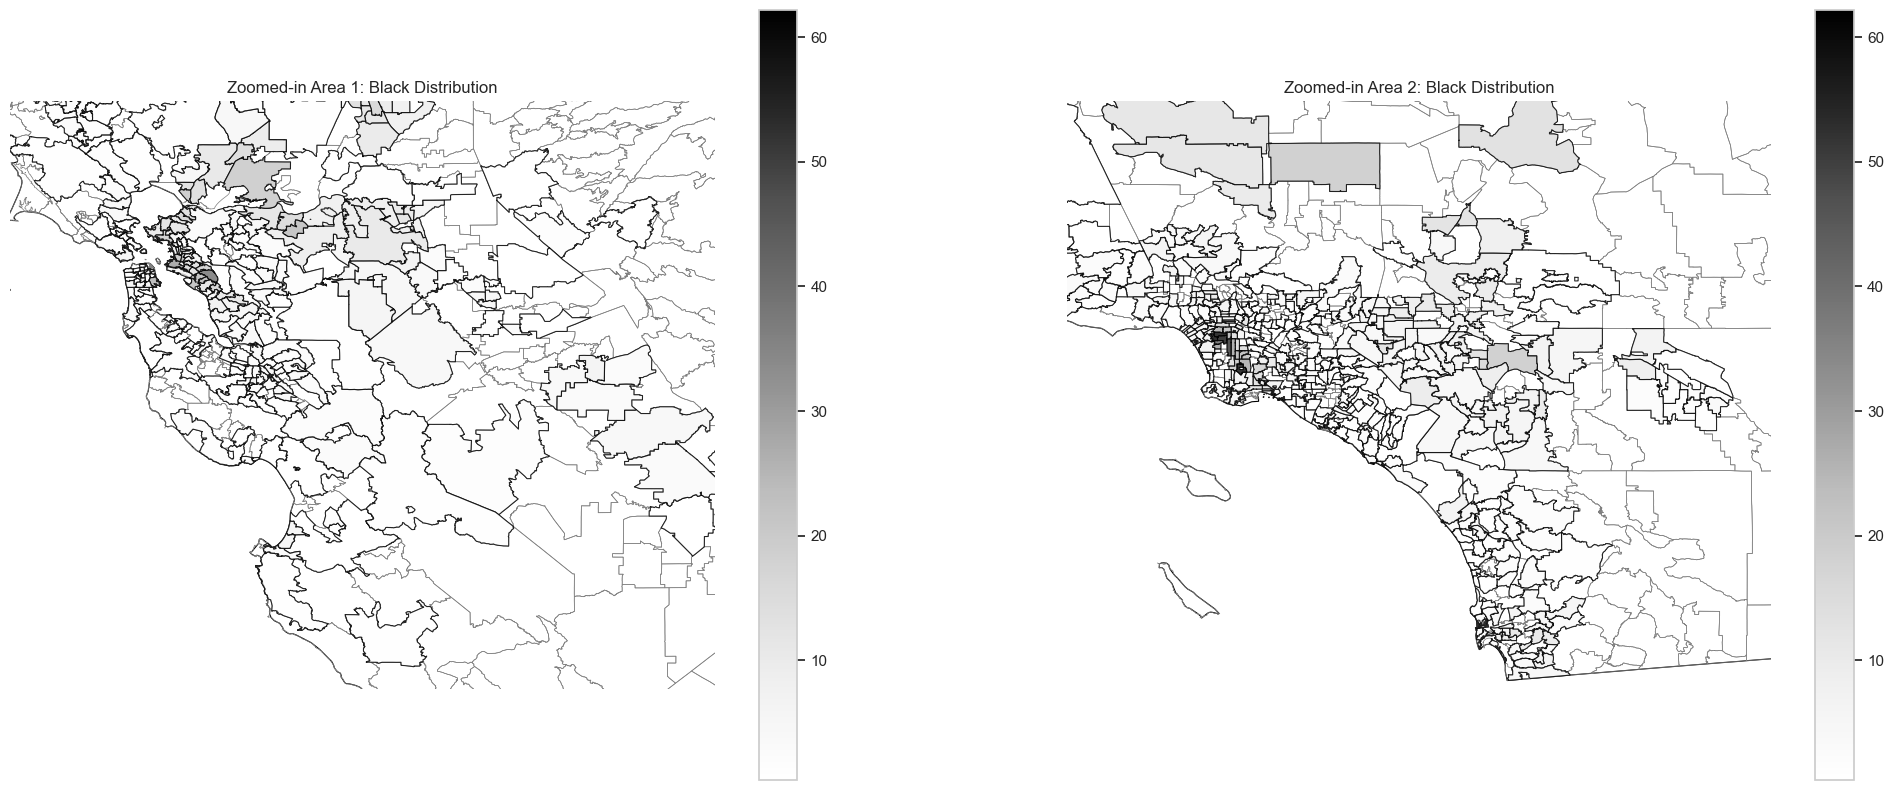

In [42]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# First subplot
xmin1, ymin1, xmax1, ymax1 = -123, 36, -120, 38.5

# Draw the first target area
state_df.query("NAME == 'California'").plot(ax=ax1, edgecolor="black", color="white", linewidth=0.8)
zip_code_df.plot(ax=ax1, edgecolor="gray", linewidth=0.5, facecolor="none")
gdf.plot(column="Percent Black alone", 
         cmap="Greys",
         vmin= 0.4,
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax1)

# Set the x and y limits for the first subplot
ax1.set_xlim(xmin1, xmax1)
ax1.set_ylim(ymin1, ymax1)

# Set the aspect ratio and turn off the axis
ax1.set_aspect(1)
ax1.axis("off")
ax1.set_title("Zoomed-in Area 1: Black Distribution")


# Define the second target area's boundaries
xmin2, ymin2, xmax2, ymax2 = -119, 32.5, -116, 35

# Draw the second target area
state_df.query("NAME == 'California'").plot(ax=ax2, edgecolor="black", color="white", linewidth=0.8)
zip_code_df.plot(ax=ax2, edgecolor="gray", linewidth=0.5, facecolor="none")
gdf.plot(column="Percent Black alone", 
         cmap="Greys",
         vmin= 0.4,
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax2)

# Set the x and y limits for the second subplot
ax2.set_xlim(xmin2, xmax2)
ax2.set_ylim(ymin2, ymax2)

# Set the aspect ratio and turn off the axis
ax2.set_aspect(1)
ax2.axis("off")
ax2.set_title("Zoomed-in Area 2: Black Distribution")

# Show the plot
plt.show()

The map clearly illustrates that, at the ZIP code level, the distribution of the Black population is nearly uniform. This finding provides strong empirical support for our assumption of racial integration.

### Map: Income

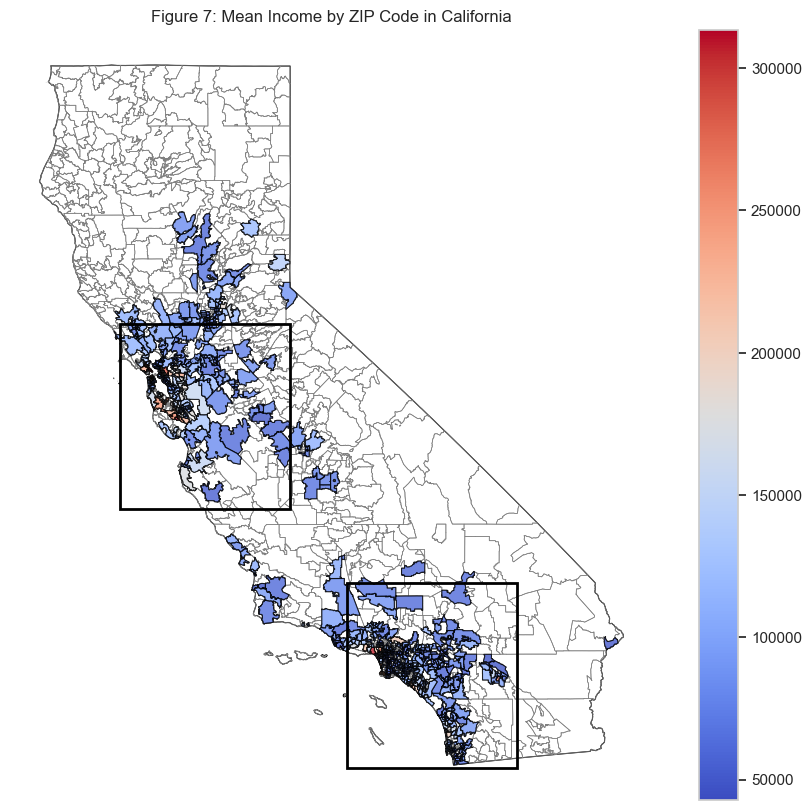

In [128]:
from matplotlib.patches import Rectangle

gdf = gpd.GeoDataFrame(merged_df, geometry="geometry")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Draw the map
state_df.query("NAME == 'California'").plot(ax=ax, edgecolor="black", color="white", linewidth=0.8)

# Overlay ZIP Code boundaries
zip_code_df.plot(ax=ax, edgecolor="gray", linewidth=0.5, facecolor="none")

# Adding data
gdf.plot(column="Mean Income", 
         cmap="coolwarm",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax)

# Draw the first target area's rectangle
rect1 = Rectangle((-123, 36), 3, 2.5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect1)

# Draw the second target area's rectangle
rect2 = Rectangle((-119, 32.5), 3, 2.5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect2)

# ratio of the y-axis to the x-axis
ax.set_aspect(1.3)
ax.axis("off")

# Title
plt.title("Figure 7: Mean Income by ZIP Code in California")

# Show the plot
plt.show()

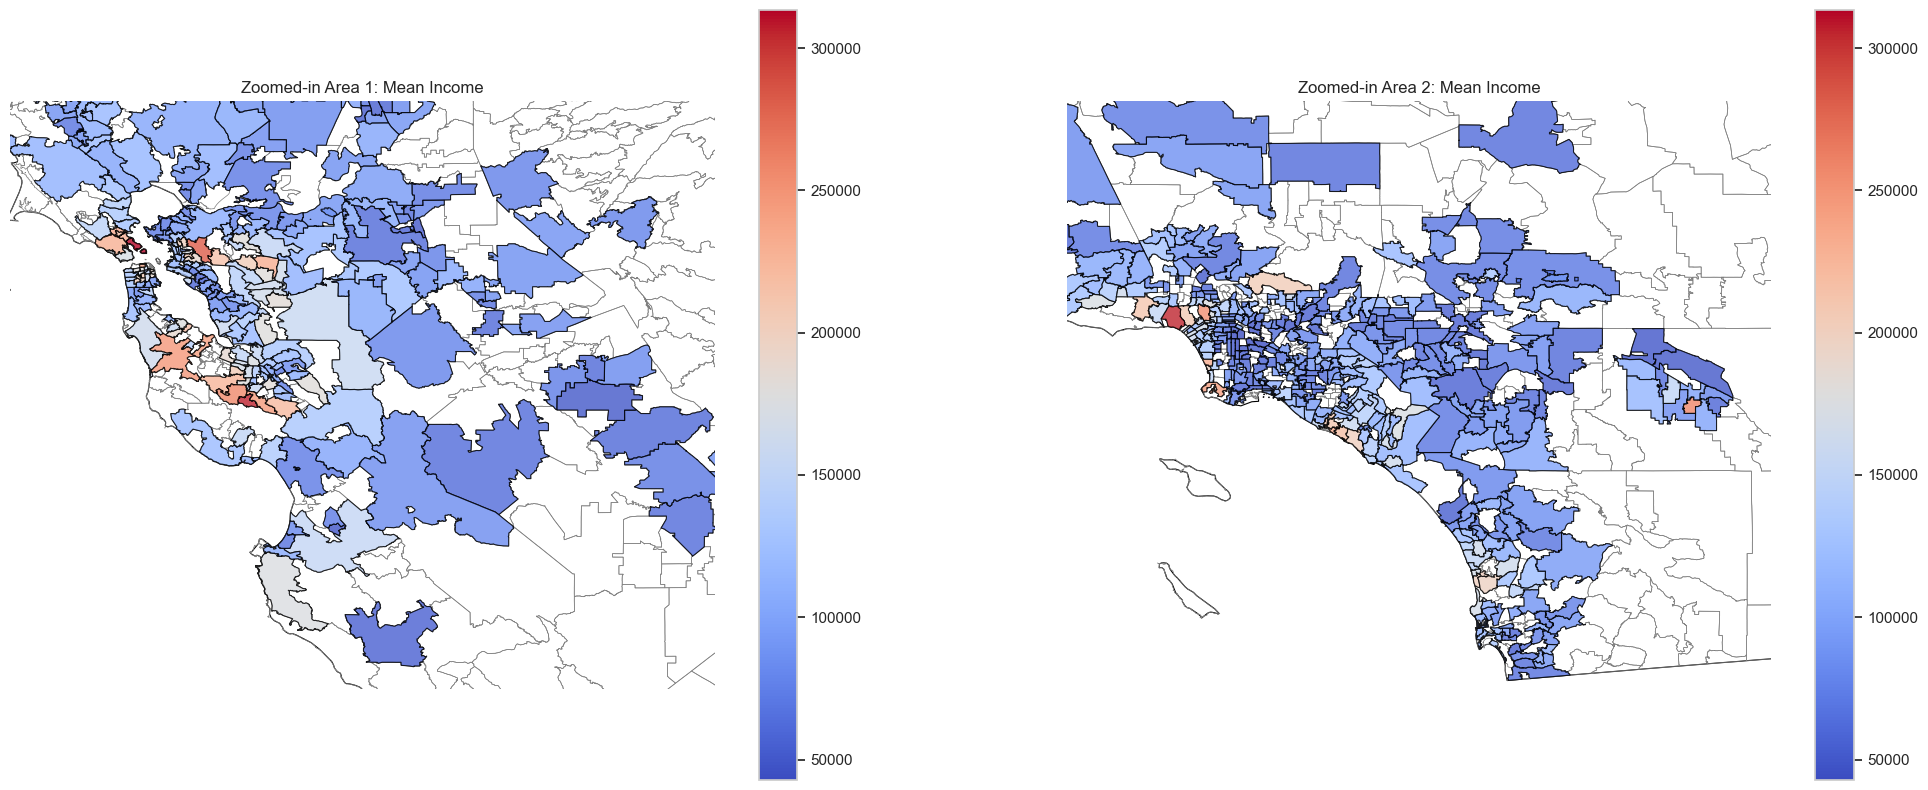

In [44]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# First subplot
xmin1, ymin1, xmax1, ymax1 = -123, 36, -120, 38.5

# Draw the first target area
state_df.query("NAME == 'California'").plot(ax=ax1, edgecolor="black", color="white", linewidth=0.8)
zip_code_df.plot(ax=ax1, edgecolor="gray", linewidth=0.5, facecolor="none")
gdf.plot(column="Mean Income", 
         cmap="coolwarm",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax1)

# Set the x and y limits for the first subplot
ax1.set_xlim(xmin1, xmax1)
ax1.set_ylim(ymin1, ymax1)

# Set the aspect ratio and turn off the axis
ax1.set_aspect(1)
ax1.axis("off")
ax1.set_title("Zoomed-in Area 1: Mean Income")


# Define the second target area's boundaries
xmin2, ymin2, xmax2, ymax2 = -119, 32.5, -116, 35

# Draw the second target area
state_df.query("NAME == 'California'").plot(ax=ax2, edgecolor="black", color="white", linewidth=0.8)
zip_code_df.plot(ax=ax2, edgecolor="gray", linewidth=0.5, facecolor="none")
gdf.plot(column="Mean Income", 
         cmap="coolwarm",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         alpha=0.8,
         ax=ax2)

# Set the x and y limits for the second subplot
ax2.set_xlim(xmin2, xmax2)
ax2.set_ylim(ymin2, ymax2)

# Set the aspect ratio and turn off the axis
ax2.set_aspect(1)
ax2.axis("off")
ax2.set_title("Zoomed-in Area 2: Mean Income")

# Show the plot
plt.show()

The mean income map indicates that coastal areas generally exhibit higher income levels, compared to other regions. This pattern, when analyzed alongside the housing price map, highlights a significant similarity between higher income and elevated housing prices at the ZIP code level.

In [45]:
regression_data

,Percent White alone,Percent Black alone,Percent Asian alone,Percent Other Race,price_per_sqft,bed,land_to_building_ratio,Mean Income,Unemployment Rate
0,15.486868,15.462217,1.695269,67.355646,319.150000,4.000,0.550000,48213.0,9.4
1,12.888381,16.747085,0.369554,69.994980,288.986000,3.800,0.580000,44361.0,8.5
2,27.576303,4.534022,25.212426,42.677248,508.997500,10.625,0.583750,85587.0,7.4
3,18.533048,5.548817,32.580587,43.337549,460.300000,6.000,0.595000,69143.0,6.3
4,16.286781,3.422597,19.019061,61.271561,410.914000,7.800,0.598000,49802.0,6.0
...,...,...,...,...,...,...,...,...,...
723,76.214551,0.568765,4.884535,18.332148,211.763333,3.000,0.593333,83981.0,5.6
724,49.775393,1.452884,25.137973,23.633750,193.500000,5.000,0.640000,80800.0,4.9
725,95.465027,0.000000,0.000000,4.534973,198.970000,4.000,0.560000,120461.0,10.0
726,72.242354,0.538490,5.561012,21.658143,583.570000,3.000,0.595000,89078.0,4.7


## Regressions

In [46]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [47]:
# Add dummy variables
regression_data['Luxury Home Indicator'] = (regression_data['bed'] > 400).astype(int)
regression_data['High Land-to-Building Ratio Indicator'] = (regression_data['land_to_building_ratio'] > 0.6).astype(int)
regression_data['Majority Black Community'] = (regression_data['Percent Black alone'] > 50).astype(int)
regression_data['Majority Asian Community'] = (regression_data['Percent Asian alone'] > 50).astype(int)

# Define the dependent variable
y = regression_data['price_per_sqft']

# ------------------------- Table 1: Bi-variate and Simple Multivariate Models -------------------------
# Model 0:
X0 = regression_data[['land_to_building_ratio', 'Mean Income', 'Unemployment Rate']]
X0 = sm.add_constant(X0)  # set the constant term to the model
model0 = sm.OLS(y, X0).fit()

# Model 1:
X1 = regression_data[['land_to_building_ratio', 'Mean Income', 'Unemployment Rate', 'Percent Black alone']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y, X1).fit()

# Model 2:
X2 = regression_data[['land_to_building_ratio', 'Mean Income', 'Unemployment Rate', 'Percent Asian alone']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()

# Model 3:
X3 = regression_data[['land_to_building_ratio', 'Mean Income', 'Unemployment Rate', 'Percent Asian alone', 'Percent Other Race']]
X3 = sm.add_constant(X3)
model3 = sm.OLS(y, X3).fit()

# ------------------------- Table 2: Full Multivariate Models -------------------------
# Model 4:
X4 = regression_data[['Percent White alone', 'Percent Black alone', 'Percent Asian alone', 
                      'Luxury Home Indicator', 'High Land-to-Building Ratio Indicator', 'bed', 
                      'land_to_building_ratio', 'Mean Income', 'Unemployment Rate']]
X4 = sm.add_constant(X4)
model4 = sm.OLS(y, X4).fit()

# Model 5:
X5 = regression_data[['Percent White alone', 'Percent Black alone', 'Percent Asian alone', 
                      'Luxury Home Indicator', 'High Land-to-Building Ratio Indicator', 
                      'Majority Black Community', 'Majority Asian Community']]
X5 = sm.add_constant(X5)
model5 = sm.OLS(y, X5).fit()

from IPython.display import HTML

# ------------------------- Output the Results -------------------------

stargazer1 = Stargazer([model0, model1, model2, model3])
stargazer1.covariate_order(['const', 'land_to_building_ratio', 'Mean Income', 'Unemployment Rate',
                            'Percent Black alone', 'Percent Asian alone' ,
                            'Percent Other Race'])
stargazer1.custom_columns(["Model 0", "Model 1", "Model 2", "Model 3"], [1, 1, 1, 1])

stargazer2 = Stargazer([model4, model5])
stargazer2.covariate_order(['const', 'Percent White alone', 'Percent Black alone', 'Percent Asian alone', 
                            'Luxury Home Indicator', 'High Land-to-Building Ratio Indicator', 'bed', 
                            'land_to_building_ratio', 'Mean Income', 'Unemployment Rate', 
                            'Majority Black Community', 'Majority Asian Community'])
stargazer2.custom_columns(["Model 4", "Model 5"], [1, 1])

html_output1 = stargazer1.render_html()
html_output2 = stargazer2.render_html()

display(HTML(html_output1))
display(HTML(html_output2))

In [119]:
from IPython.display import HTML

# ------------------------- Output the Results with Main Title -------------------------

# Add main title for Table 1
html_output1_with_title = """
<h2>Regression Table 1</h2>
""" + html_output1

# Add main title for Table 2
html_output2_with_title = """
<h2>Regression Table 1</h2>
""" + html_output2

# Display HTML with main title
display(HTML(html_output1_with_title))
display(HTML(html_output2_with_title))

# Optionally, save as HTML files
with open('regression_table_1.html', 'w') as f:
    f.write(html_output1_with_title)

with open('regression_table_2.html', 'w') as f:
    f.write(html_output2_with_title)

### Interpretation ###

Most of $X$ variables are explained in Variable Explanation Part. Therefore we will just breifly summrize the reasons.<br>
1. Land to Building Raito: higher land scarcity tends to increase the value of land and property, leading to higher housing prices
2. Mean Income: Higher average income is positively correlated with housing prices, as wealthier households can afford higher rents or purchase higher-valued homes.
3. Unemployment Rate: Areas with higher unemployment tend to have lower housing prices due to reduced disposable income and lower economic activity
4. Precent Black: one of our main focus.
5. precent Asian and other: another focus.
6. Precent White: used to control.
7. Luxury Home: dummy variable that relats to housing price.
8. Employment: essential economic indicator.

Economic Reasoning Behind the Regressions:<br>
1. Model 0 (Basic model): Tests the impact of basic economic variables (land-to-building ratio, income, unemployment) on housing prices. It serves as a benchmark to understand the general influence of economic conditions.
2. Model 1 and Model 2: Adds demographic variables (Percent Black alone, Percent Asian alone). These help understand how racial composition correlates with housing prices
3. Model 3: Further adds Percent Other Race to include a broader racial diversity factor in explaining housing prices

To evaluate the performance of my regressions, I will focus on the following measures:<br>
1. The  Model 1 shows that the black population does not significantly effect housing price, resulting in a sgnificant value of 0.3891.
2. For Model 2, the R² is 0.538, which indicates that approximately 54% of the variation in housing prices is explained by the Asian Proportion in the model.
4. In Model 3, we capture that, along with all races, Asian strongly effect Housing price, with a  positive coefficient of 2.964 (significant at the 1% level). Beside, the positive coefficient of 1.554 (significant at the 1% level) suggests that areas with higher proportions of "Other Race" populations also experience higher housing prices.
5. The residual standard error for Model 3 is 154.472, which suggests reasonable fit.

The result of regression data, African American populations show a weak relationship with prices, Asian and other racial groups show a positive correlation, support our assumption. Implys a hiden mechanism:<br>
1. Due to racial integration, the correlation of Housing price and the Black population proportion is weak.
2. Regions with high housing prices tend to have strong economic conditions, attracting new immigrants and increasing racial diversity.

# Final Project

## Potential Data to Scrape

In our previous California state-level dataset, crime rate data at the ZIP code level ( $CR$ ), which served as a potential confounding factor affecting housing prices, was not included due to a lack of available data. This implies our research may ignore the fact that higher $CR$ may depress property values, while safer neighborhoods tend to attract more buyers. Upon further searching, we discovered that relevant crime data is available on Wikipedia under the page California locations by crime rate (URL: https://en.wikipedia.org/wiki/California_locations_by_crime_rate).

## Potential Challenge

There is no downloadable CSV or structured dataset available on the site. In the meantime, due to the high volume and dynamic nature of the data, along with the fact that crime statistics are frequently updated, manual collection would be inefficient and error-prone. Therefore, we decide to employ web scraping to automate the extraction process. This method ensures access to large-scale, up-to-date, and structured data efficiently, saving time and improving data quality and consistency for our analysis.

## Scraping Data from a Website

We first access the target website and set a User-Agent in the request header to simulate a browser request, ensuring the server does not block the connection due to automated behavior.

In [48]:
# To bypass the issue, this cell sets a user-agent in the request header to mimic a request from a web browser. 
import requests

web_url = 'https://en.wikipedia.org/wiki/California_locations_by_crime_rate'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(web_url, headers=headers)

A 200 response code confirms a successful connection.

In [49]:
response.status_code

200

BeautifulSoup is used to parse the HTML content of the page.

In [50]:
from bs4 import BeautifulSoup
soup_object = BeautifulSoup(response.content)

Parsing includes three steps:

1. Locate the corresponding division level, in this case, with the class attribute 'mw-content-ltr mw-parser-output'.

2. Within this division, we search through all table, indentify the desired table.

3. Extract data from the selected table. Based on the HTML structure property, we iterate through the table rows using tr tags to extract the required information.

In [51]:
div = soup_object.find('div', 'mw-content-ltr mw-parser-output' )
data_tables = div.find_all('table') 
data_table = data_tables[2]
all_values = data_table.find_all('tr')

Finally, we structure the data into a data frame format:<br>
1. An empty DataFrame ca_crime_df is initialized with predefined columns to store structured crime data. <br>
2. The loop iterates through each row of the previously parsed HTML table (excluding the header). For each row, it extracts td elements and retrieves the textual content for five key fields: city, county, population density, violent crime rate, and property crime rate. <br>
3. These values are cleaned and sequentially inserted into the DataFrame.

In [52]:
ca_crime_df = pd.DataFrame(columns = ['City','County','Population Density', 'Violent Crime per 1000', 'Property Crime per 1000']) # Create an empty dataframe
ix = 0 # Initialise index to zero

for row in all_values[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    city = values[0].text.replace("\n", "").strip()
    county = values[1].text.replace("\n", "").strip()
    pop_density = values[3].text.replace("\n", "").strip()
    vio_crime_rate = values[5].text.replace("\n", "").strip()
    prop_crime_rate = values[7].text.replace("\n", "").strip()
    
    ca_crime_df.loc[ix] = [city, county, pop_density, vio_crime_rate, prop_crime_rate] # Store it in the dataframe as a row
    ix += 1

## Applying Method to Evaluate $CR$

To integrate various types of crimes into a single measure, we construct a composite Crime Index using a weighted average approach. The index assigns greater weight to more severe offenses, specifically Violent Crimes, while assigning a lower weight to Property Crimes.

The general form of the index is:<br><br>
$Crime Index=β1⋅Violent Crime+β2⋅Property Crime$
<br><br>
In our study, we set $β1$ = 0.7, $β1$ ​= 0.7, reflecting the higher societal and economic impact of violent crimes relative to property crimes. This hybrid index allows for a more meaningful comparison of overall crime exposure across regions.

In [53]:
# Clean the data: Remove commas and convert to numeric (formatting)
ca_crime_df['Violent Crime per 1000'] = ca_crime_df['Violent Crime per 1000'].replace(',', '').astype(float)
ca_crime_df['Property Crime per 1000'] = ca_crime_df['Property Crime per 1000'].str.replace(',', '').astype(float)

# Set the weights for violent and property crime
weight_violent = 0.7
weight_property = 0.3

# Calculate the crime index using the weighted average
ca_crime_df['Crime Index'] = (
    weight_violent * ca_crime_df['Violent Crime per 1000'] +
    weight_property * ca_crime_df['Property Crime per 1000']
)

ca_crime_df.drop(columns=['Population Density', 'Violent Crime per 1000', 'Property Crime per 1000'], inplace=True)

In [54]:
# Merge the crime data with the county geo based on County name
ca_crime_df['County'] = ca_crime_df['County'].str.strip()
county_geo = county_geo.merge(ca_crime_df, left_on='County', right_on='County', how='inner')

In [55]:
ca_crime_aggregated = county_geo.groupby('County').agg(
    {'Crime Index': 'mean', 'geometry': 'first'}).reset_index()


## Visualizing the Scraped Datas

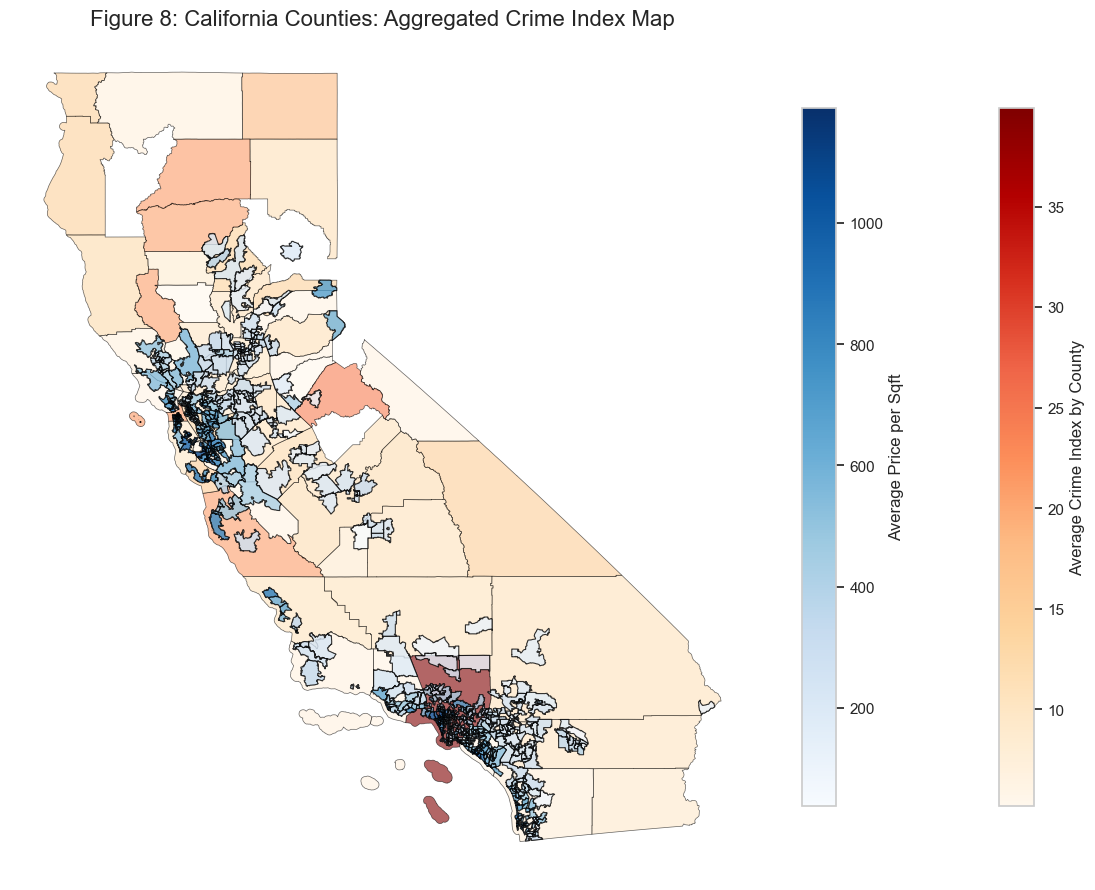

In [120]:
ca_crime_aggregated = gpd.GeoDataFrame(ca_crime_aggregated, geometry='geometry')

# draw the map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ca_crime_aggregated.plot(
    column='Crime Index',
    cmap='OrRd',
    linewidth=0.5, 
    edgecolor='black',
    legend=True,
    alpha=0.6,
    legend_kwds={'label': "Average Crime Index by County", 'shrink': 0.6},
    ax=ax
)

# Adding data
gdf.plot(column="price_per_sqft", 
         cmap="Blues",
         linewidth=0.8, 
         edgecolor="black",
         legend=True,
         legend_kwds={'label': "Average Price per Sqft", 'shrink': 0.6},
         alpha=0.8,
         ax=ax)

ax.set_title('Figure 8: California Counties: Aggregated Crime Index Map', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()

The figure presents an aggregated crime index map for California counties overlaid with average price per square foot at the ZIP code level. The background shading (red) indicates the county-level crime index, while the foreground ZIP code areas are colored from light blue to deep navy based on housing prices.


From the map, a clear negative correlation between crime rates and housing prices is observed. As we can seenIn Southern California—particularly around Los Angeles and the Inland Empire—many counties exhibit high crime indices (shaded in dark orange/red), whereas ZIP code-level housing prices in these same areas remain predominantly low (light blue).


Parts of Northern California, such as the Bay Area (San Francisco, Santa Clara, and Alameda counties), display relatively lower crime indices yet much higher housing prices. This implies that in high-demand areas, where driven by tech-sector employment and limited housing supply, housing prices may remain elevated despite moderate crime rates.


Overall, though the strength of this relationship appears to be heterogeneous across regions, the visualization still indicates that crime rates and housing prices are negatively related, confirming the hypothesis that $CR$ served as a potential confounding factor affecting housing prices.

## Regression Tree

In [57]:
regression_data.to_csv('regression_data.csv', index=False)

Objective function is built with research price indicator, $price/ft^2$, as y variable, along with REG X variables.

Regression Tree Objective Function:<br>

$$
\min_{m=1}^M \sum_{i \in R_m} (y_i - \hat{y}_{R_m})^2
$$

Notice that price indicator is logrithed to capture changes.

In [59]:
# Define features (Xs) and target (y)
X_all = regression_data.drop(columns=['price_per_sqft'], axis=1).copy()
y = np.log(regression_data['price_per_sqft'])
regression_data["log_price"] = y

Sklearn is used in our study for Machine Learning.

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# First model: include only justified variables (based on economic reasoning)
X_justified = regression_data[[
    'Percent Black alone', 'Percent Asian alone', 'Mean Income',
    'Unemployment Rate', 'bed', 'land_to_building_ratio'
]]

# Train-test split
X_train_just, X_test_just, y_train, y_test = train_test_split(X_justified, y, test_size=0.2, random_state=42)
X_train_all, X_test_all, _, _ = train_test_split(X_all, y, test_size=0.2, random_state=42)

# 1. Regression Tree (Justified Features)
tree_just = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_just.fit(X_train_just, y_train)
y_pred_just = tree_just.predict(X_test_just)
mse_just = mean_squared_error(y_test, y_pred_just)

# 2. Regression Tree (All Features)
tree_all = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_all.fit(X_train_all, y_train)
y_pred_all = tree_all.predict(X_test_all)
mse_all = mean_squared_error(y_test, y_pred_all)

Regularization Parameters used in ML is max depth. In order to prevent over-fitting while keep the mean squared error(MSE) in a resonable interval, max depth of 4 is selected with random state of 42.

### Tree Plot:

MSE is checked before plotting.

In [64]:
print(f"Mean Squared Error (Justified Features): {mse_just:.4f}")
print(f"Mean Squared Error (All Features): {mse_all:.4f}")

Mean Squared Error (Justified Features): 0.1779
Mean Squared Error (All Features): 0.1751


Notice that there is no significant MSE difference between Justified Features Model and ALL Features Model. This indicates that Justified Features Variables already captured most economical Impact. Therefore, in order to keep interpretation's simplisity, only Justified Features Model Tree Plot will be display and interpreted.

#### Regression Tree with Justified Features

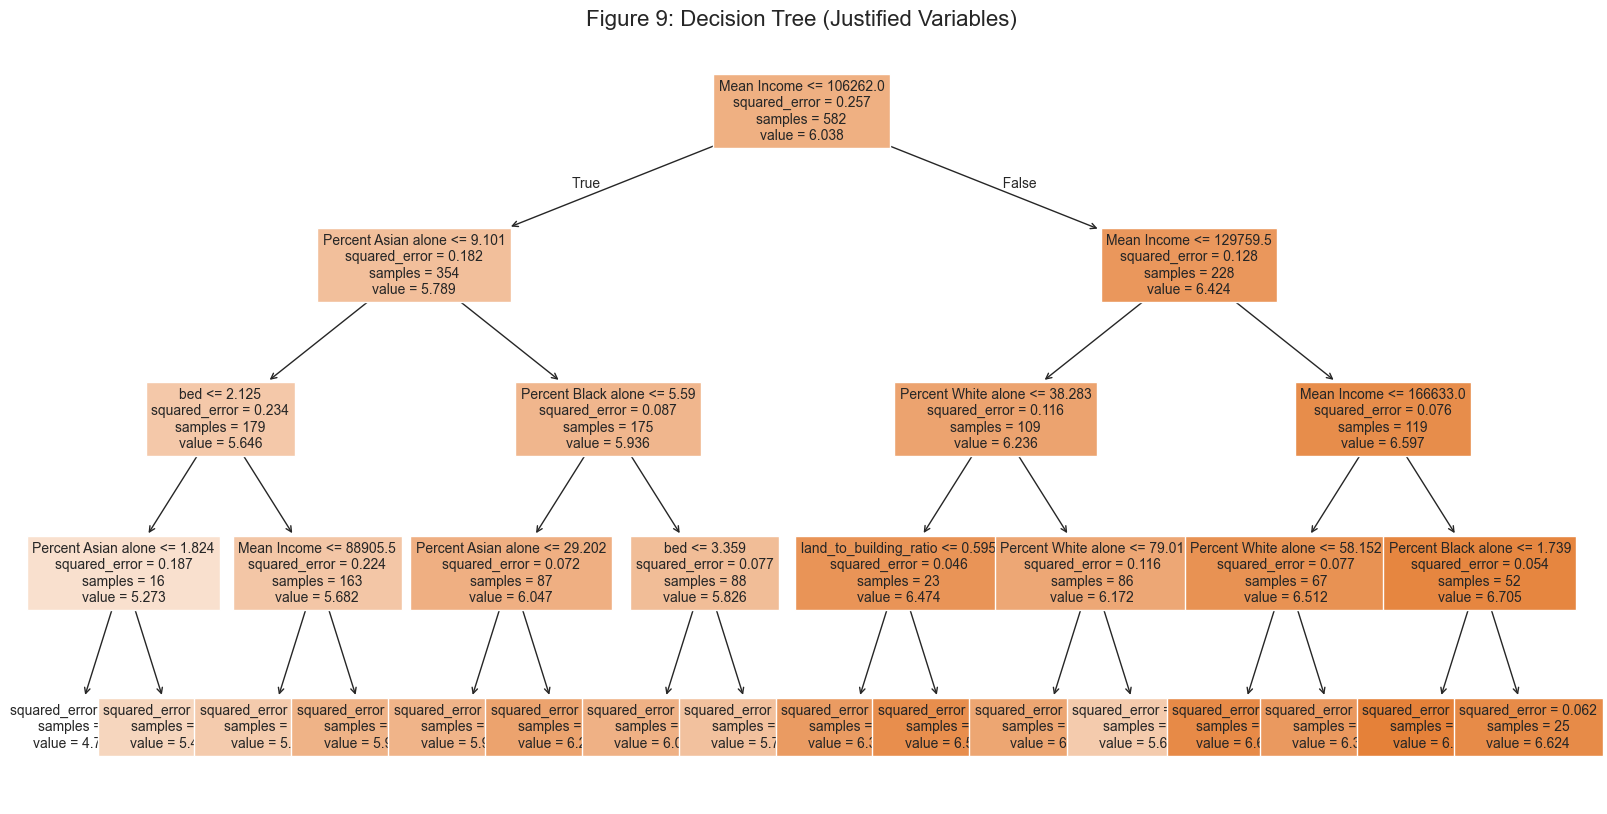

In [126]:
# Output tree plot 1
plt.figure(figsize=(20, 10))
plot_tree(tree_all, feature_names=X_train_all.columns, filled=True, fontsize=10)
plt.title("Figure 9: Decision Tree (Justified Variables)", fontsize=16)
plt.show()

The regression tree divides the data into several regions, each representing a category of housing price range. Specifically:<br>
1. If Mean Income > 75,000 and Percent Asian alone > 20%, then housing prices are significantly higher.
<br>
2. If Unemployment Rate > 8%, then housing prices are often below the average.
<br>

These splits indicate:

1. Income is the most critical determining factor.

    
2. Areas with a high proportion of Asian population tend to have higher housing prices.


3. Regions with high unemployment rates experience significantly suppressed housing prices.

Which follows OLS regression result and mapping interpretation and support the hypothsis.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Fit the Random Forest model

In [ ]:
# 3. Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_all, y_train)
rf_importances = rf_model.feature_importances_

#### Importance Matrix

C:\Users\BX\AppData\Local\Temp\ipykernel_13360\3769201912.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


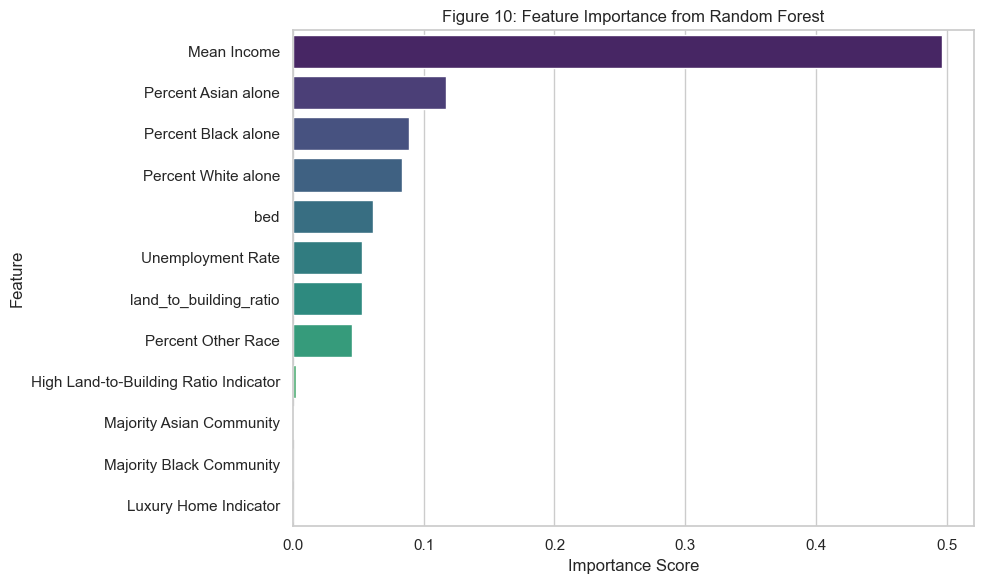

In [127]:

feature_names = X_train_all.columns
importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Figure 10: Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The matrix indicates:

Most Important Variables

1. Mean income is the most explanatory variable in housing price prediction, with a weight close to 60%, far exceeding other variables. Follows the fact that in areas with higher income, residents have stronger purchasing power, which naturally drives up housing prices.

2. Asian populatoin is the only racial variable that significantly affects housing prices, along with the fact that areas with a high proportion of Asians (e.g., the Bay Area, Irvine) are often associated with high-tech industries, higher education levels, and high-income groups, all of which push housing prices up.

3. The reltion between Percent of White and Black population in current time, contrary to Bayer, P., McMillan, R., & Rueben, K.'s discovery in 2002, seems become more complex. As the model shows similarly weakly related to housing price. 

## OLS vs ML

In the linear regression model statistically significant relationships between housing prices and racial composition, especially the strong positive effect of Asian and Other racial groups, is shown by coefficent. However, it lacked the capacity to capture complex interaction effects and non-linear patterns.

The regression tree and random forest models not only confirmed these findings but also revealed conditional pathways (e.g., Asian proportion influences housing price only when income exceeds a threshold), and identified variable importance in a data-driven way.

## Conclusion

Our study examines the relationship between racial composition and housing prices at the state level. Through data analysis, we find that the proportion of Black residents does not significantly affect housing prices, which is likely due to racial integration or the "averagization" effect. However, a strong positive correlation between the proportion of Asian and other minority residents and higher housing prices was observed. Based on correlations between economic variables, this could be a result of better career prospects and access to wealth, which drives migration to these states. Therefore, increasing racial diversity within a state.

## Reference

 1. Bayer, P., McMillan, R., & Rueben, K. (2002). The causes and consequences of residential segregation: An equilibrium analysis of
 neighborhood sorting (Working Paper). Yale University.
 2. Rosen, S. (1974). Hedonic prices and implicit markets: Product differentiation in pure competition. Journal of Political Economy,
 82(1), 34–55.
 3. Gibbons, S. (2004). The costs of urban property crime. The Economic Journal, 114(499), F441–F463
 4. Liu, J., Farahani, H., & Serota, R. A. (2023). Exploring distributions of house prices and house price indices. arXiv preprint
 arXiv:2312.14325
 5. Bajari, P., & Kahn, M. E. (2003). Estimating housing demand with an application to explaining racial segregation in cities (NBER
 Working Paper No. 9891). National Bureau of Economic Research

6. Yang, H., & Liu, M. (2022). Analysis of the Correlation Between Crime Rate and Housing Price in Washington, D.C., USA Based on Big Data.

7. Joint Center for Housing Studies of Harvard University. (2022). In Nearly Every State, People of Color Are Less Likely to Own Homes Compared to White Households.

8. Brookings Institution. (2022). How racial bias in appraisals affects the devaluation of homes in majority-Black neighborhoods